# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [1]:
import pathlib

#Packages to use pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

# TensorFlow and tf.keras
import tensorflow as tf

#Visualization
#!pip install --upgrade plotly
import plotly.figure_factory as ff
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Packages to data management
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

#Usual libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import random
import time

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
dataset_path = 'diabetes_data_upload.csv'

--2023-09-24 23:58:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘diabetes_data_upload.csv.2’

diabetes_data_uploa     [ <=>                ]  33.87K  --.-KB/s    in 0.06s   

2023-09-24 23:58:36 (539 KB/s) - ‘diabetes_data_upload.csv.2’ saved [34682]



In [3]:
import csv

with open('diabetes_data_upload.csv') as inp, open('temp.csv', 'w') as out:
    reader = csv.reader(inp)
    writer = csv.writer(out, delimiter=',')
    #No need to use `insert(), `append()` simply use `+` to concatenate two lists.
    writer.writerow(['ID'] + next(reader))
    #Iterate over enumerate object of reader and pass the starting index as 1.
    writer.writerows([i] + row for i, row in enumerate(reader, 1))

In [4]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [5]:
gender = dataset.pop('Gender')
dataset['gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
  if column not in ['Gender', 'class', 'Age']:
    column_class = dataset.pop(column)
    dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()


,Age,gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [6]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age
dataset.tail()


#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')


In [7]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.



---

Para el desarrollo de esta tarea, se escogió el framework de tensorflow. Así, para cada red neuronal definida, se le deben agregar las capas con sus dimensiones y funciones de activación. Por otro lado, los hiperparámetros `learning_rate`, `epochs`, `batch_size` y `batches aleatorios` se irán modificando en cada pregunta según corresponda.

In [8]:
# Crear modelo red neuronal

tf.random.set_seed(1234)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
# Definir parámetros y compilar

LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 20
tf.random.set_seed(1234)

model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [10]:
# Entrenar red

tf.random.set_seed(1234)

tf_train_0 = model.fit(X_train, Y_train.reshape(-1), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False)

print('\n Conjunto test \n')
print(model.evaluate(X_test, Y_test))

Epoch 1/50
21/21 [==============================] - 2s 7ms/step - loss: 0.6402 - accuracy: 0.6145
Epoch 2/50
21/21 [==============================] - 0s 8ms/step - loss: 0.6192 - accuracy: 0.6145
Epoch 3/50
21/21 [==============================] - 0s 5ms/step - loss: 0.6003 - accuracy: 0.6145
Epoch 4/50
21/21 [==============================] - 0s 5ms/step - loss: 0.5820 - accuracy: 0.6482
Epoch 5/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5634 - accuracy: 0.6892
Epoch 6/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5449 - accuracy: 0.6916
Epoch 7/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5262 - accuracy: 0.7012
Epoch 8/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5069 - accuracy: 0.7012
Epoch 9/50
21/21 [==============================] - 0s 4ms/step - loss: 0.4872 - accuracy: 0.7133
Epoch 10/50
21/21 [==============================] - 0s 5ms/step - loss: 0.4675 - accuracy: 0.7470
Epoch 11/50
21/21 [

Como se puede ver en esta iteración, el modelo logra llegar a un 93% de accuracy como fue sugerido en el enunciado, sin embargo, esto depende de ciertos valores aleatorios de tensorflow.  
Ejecutando lo anterior hartas veces, se pudo concluir que el rango de accuracy varía entre 89% y 96%.

In [11]:
# Printear resultados en conjunto test

results = model.evaluate(X_test,  Y_test, verbose = 0)
print('Test loss: ', results[0])
print('Test Accuracy: ', results[1])

Test loss:  0.15855772793293
Test Accuracy:  0.932692289352417


Para poder visualizar la función de pérdida de la red, se usa la librería `plotly` para obtener un mejor resultado. En caso de que no sea posible ver estos gráficos, también hay una versión en `matplotlib`.

In [12]:
# Graficar loss vs épocas

fig = px.line(tf_train_0.history, x=range(EPOCHS), y='loss', title="Train Loss").update_layout(
    xaxis_title="Epoch", yaxis_title="Loss", title_x=0.5)
fig.show()

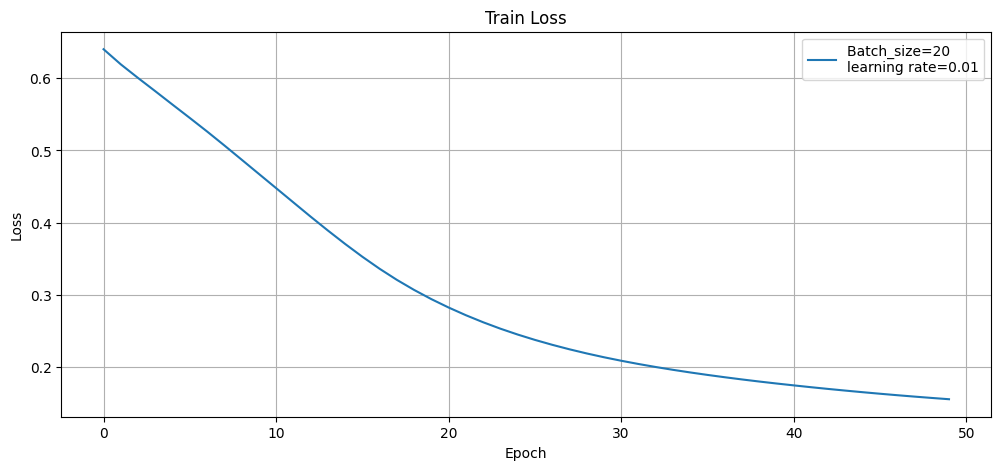

In [13]:
# Gráfico anterior en matplotlib

plt.figure(figsize=(12, 5))

plt.plot(range(EPOCHS), tf_train_0.history['loss'], label='Batch_size=20 \nlearning rate=0.01')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.grid()
plt.show()

Como se puede ver en el gráfico anterior, la red con los parámetros de `batch_size=20` y `learning_rate=0.01` la red tiene un rendimiento considerablemente bueno, al menos con lo que respecta a la métrica de `accuracy` pues alcanza sobre un 93% dependiendo un poco de la aleatoriedad de tensorflow (la idea sería fijar semillas pero no pude conseguir esto para hacer resultados replicables, lo siento :c).

Por otro lado, las épocas estan definidas de manera arbitraria como 50. Solamente se considera que terminen de entrenar en un tiempo acotado $<60$ (s) cada red.

# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [14]:
# Generar lista de batch_size e iterar sobre ella

lista_batches = [1, 80, 200, X_train.shape[0]]
lista_trains = []
tf.random.set_seed(1234)

for batch_size in lista_batches:

  model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  LEARNING_RATE = 0.01
  EPOCHS = 50
  BATCH_SIZE = batch_size

  model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  tf_train = model.fit(X_train, Y_train.reshape(-1), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0)
  lista_trains.append(tf_train)

In [15]:
# Graficar losses de las redes

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=tf_train_0.history['loss'], mode='lines+markers', name='Batch size: 20'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains[0].history['loss'], mode='lines+markers', name='Batch size: 1'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains[1].history['loss'], mode='lines+markers', name='Batch size: 80'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains[2].history['loss'], mode='lines+markers', name='Batch size: 200'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains[3].history['loss'], mode='lines+markers', name='Batch size: 415'))

fig.update_layout(title='Loss con diferentes tamaños de batch',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                   title_x=0.5,
                   width=1200,
                   height=500)

fig.show()

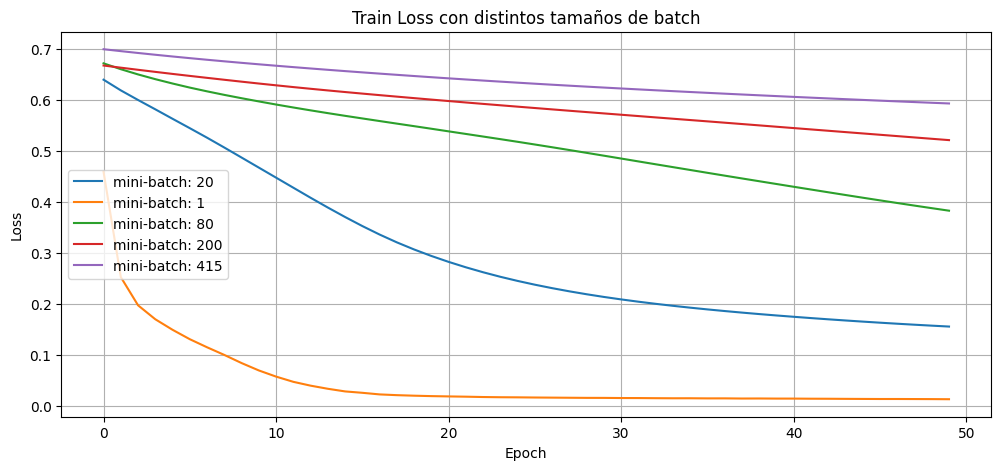

In [16]:
# Gráfico anterior en matplotlib

plt.figure(figsize=(12, 5))

plt.plot(range(EPOCHS), tf_train_0.history['loss'], label='mini-batch: 20')
plt.plot(range(EPOCHS), lista_trains[0].history['loss'], label='mini-batch: 1')
plt.plot(range(EPOCHS), lista_trains[1].history['loss'], label='mini-batch: 80')
plt.plot(range(EPOCHS), lista_trains[2].history['loss'], label='mini-batch: 200')
plt.plot(range(EPOCHS), lista_trains[3].history['loss'], label='mini-batch: 415')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss con distintos tamaños de batch')
plt.legend()
plt.grid()
plt.show()

Como se puede apreciar en el gráfico anterior, los peores resultados son las redes definidas con el tamaño de mini batches: 415, 80 y 200.  
Esto puede deberse a que son valores reativamente altos con respecto al tamaño del dataset, por lo cual se iteran pocas veces entregando peores resultados.  
Por otro lado, los mejores rendimientos son los tamaños de mini bacth 20 y 1.  

Cabe destacar que, a pesar de estos resultados, la red con `batch_size=1`, se demora considerablemente más que las otras. Debido a esto, es que en un problema como este (más sencillo y relativamente pocos datos) resulta bien, sin embargo, la escalabilidad de este parámetro puede ser muy mala para problemas más grandes y complejos.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [17]:
# Generar lista de learning rates e iterar sobre ella

lista_lr = [0.000001, 0.001, 0.1, 0.5]
lista_trains_lr = []
tf.random.set_seed(1234)

for lr in lista_lr:

  model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

  LEARNING_RATE = lr
  EPOCHS = 50
  BATCH_SIZE = 20

  model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LEARNING_RATE),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  tf_train = model.fit(X_train, Y_train.reshape(-1), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=False, verbose=0)
  lista_trains_lr.append(tf_train)

In [18]:
# Graficar losses de las redes

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=tf_train_0.history['loss'], mode='lines+markers', name='lr: 0.01'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains_lr[0].history['loss'], mode='lines+markers', name='lr: 0.000001'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains_lr[1].history['loss'], mode='lines+markers', name='lr: 0.001'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains_lr[2].history['loss'], mode='lines+markers', name='lr: 0.1'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=lista_trains_lr[3].history['loss'], mode='lines+markers', name='lr: 0.5'))

fig.update_layout(title='Loss con diferentes learning rates',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                   title_x=0.5,
                   width=1200,
                   height=500)

fig.show()

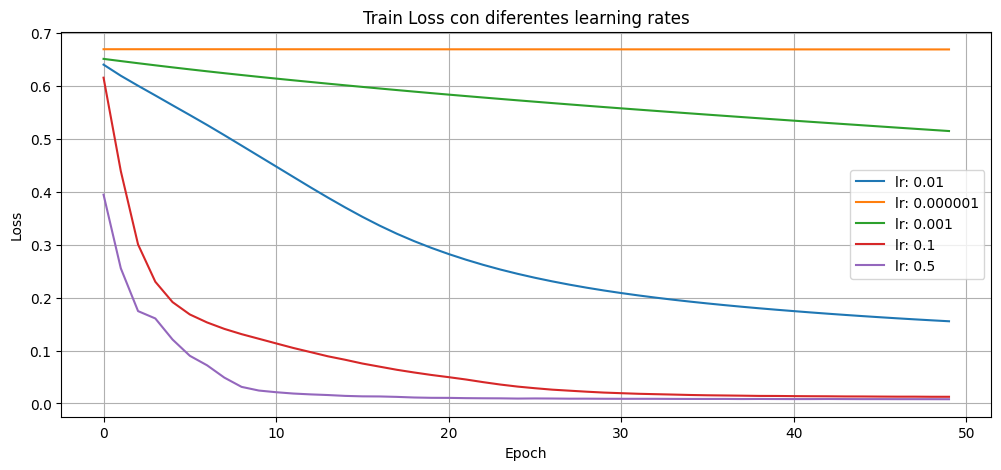

In [19]:
# Gráfico anterior en matplotlib

plt.figure(figsize=(12, 5))

plt.plot(range(EPOCHS), tf_train_0.history['loss'], label='lr: 0.01')
plt.plot(range(EPOCHS), lista_trains_lr[0].history['loss'], label='lr: 0.000001')
plt.plot(range(EPOCHS), lista_trains_lr[1].history['loss'], label='lr: 0.001')
plt.plot(range(EPOCHS), lista_trains_lr[2].history['loss'], label='lr: 0.1')
plt.plot(range(EPOCHS), lista_trains_lr[3].history['loss'], label='lr: 0.5')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train Loss con diferentes learning rates')
plt.legend()
plt.grid()
plt.show()

En la figura anterior se puede ver la evolución de la función de pérdida como en los gráficos de las partes anteriores pero esta vez cambiando el parámetro de `learning_rate`.  
En el resultado se puede ver como valores muy bajos como $0.001$ y $0.000001$ no se ajustan muy bien a este problema pues no se mueven a valores muy lejanos al actual por lo que la función de pérdida tiende a mantenerse o bajar levemente.  
Por el contrario, con valores más altos como $0.01, 0.1$ y $0.5$ la red tiende rápidamente a $0$ que es lo ideal, sin embargo, al igual que pasaba en la pregunta anterior, estos valores dependen de qué tan complejo sea el problema que se esté resolviendo y cuánto tiempo se está dispuesto a esperar para la convergencia de la función de pérdida.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [20]:
# Generar lista de learning rates e iterar sobre ella

LEARNING_RATE = 0.01
EPOCHS = 50
BATCH_SIZE = 20
tf.random.set_seed(1234)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(150, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

tf_train_p3 = model.fit(X_train, Y_train.reshape(-1), epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose='auto')

print('\n Conjunto test \n')
print(model.evaluate(X_test, Y_test))

Epoch 1/50
21/21 [==============================] - 1s 3ms/step - loss: 0.6455 - accuracy: 0.6048
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.6047 - accuracy: 0.6145
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5770 - accuracy: 0.6145
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.6145
Epoch 5/50
21/21 [==============================] - 1s 33ms/step - loss: 0.5352 - accuracy: 0.6651
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5156 - accuracy: 0.7325
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4961 - accuracy: 0.7398
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4761 - accuracy: 0.7614
Epoch 9/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4565 - accuracy: 0.8024
Epoch 10/50
21/21 [==============================] - 0s 3ms/step - loss: 0.4366 - accuracy: 0.8145
Epoch 11/50
21/21 

In [21]:
# Graficar loss vs épocas

fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=tf_train_0.history['loss'], mode='lines+markers', name='Batches no aleatorios'))

fig.add_trace(go.Scatter(x=list(range(EPOCHS)), y=tf_train_p3.history['loss'], mode='lines+markers', name='Batches aleatorios'))

fig.update_layout(title='Evolución de función de pérdida',
                   xaxis_title='Epoch',
                   yaxis_title='Loss',
                   title_x=0.5,
                   width=1200,
                   height=500)

fig.show()

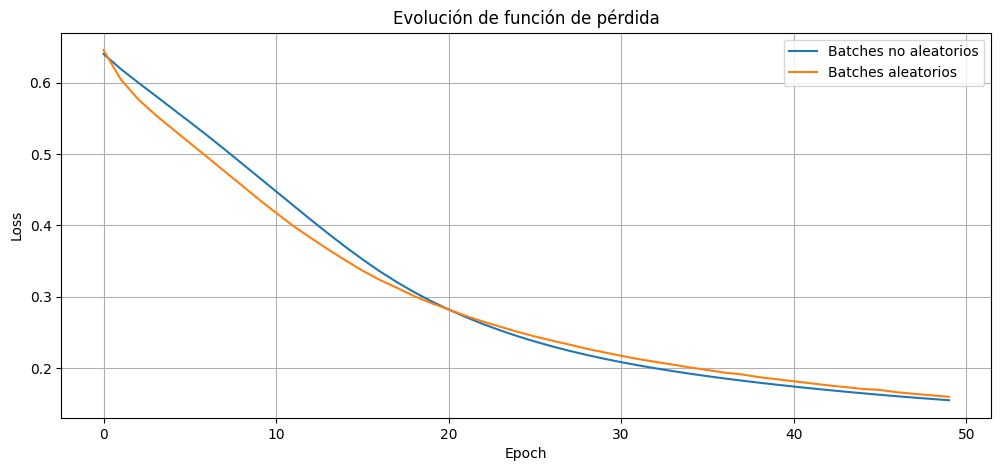

In [22]:
# Gráfico anterior en matplotlib

plt.figure(figsize=(12, 5))

plt.plot(range(EPOCHS), tf_train_0.history['loss'], label='Batches no aleatorios')
plt.plot(range(EPOCHS), tf_train_p3.history['loss'], label='Batches aleatorios')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de función de pérdida')
plt.legend()
plt.grid()
plt.show()

En esta última parte se grafican las redes con los mismos parámetros: `batch_size=20` y `learning_rate=0.01` pero con distinta forma de escoger los mini batches antes de cada época, ya sean aleatorios o definidos desde la primera iteración. Esta modalidad se define con un parámetro dentro de la función `train` de tensorflow.  

Como se puede ver en el resutado, el mejor rendimiento lo obtiene, por poca diferencia, la red que no genera sus batches de manera aleatoria. Sin embargo, es importante notar que, según el problema que se esté resolviendo, usualmente es mejor mantener el entrenamiento de manera aleatoria para escoger los batches, esto pues el modelo funcionará de manera más insesgada y puede tender a obtener mejores resultados en la práctica.  

Por último, cabe decir que los resultados comentados en este notebook están sujetos a lo que se ve en los gráficos actualmente. Si se llegase a ejecutar nuevamante podría cambiar alguna conclusión con respecto a los rendimientos de las redes neuronales con ciertos hiperparámetros.